In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint



[02:34:48 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '10010034', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010038', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8010233', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '10010040', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010033', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010036', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8010231', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '10010035', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010037', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010039', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8010232', 'name': 'Games', 'system': F

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[02:34:52 -0600] [INFO]: Graph 'SteamGraph' exists.
[02:34:52 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [ ]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jSsvsD6--A', 'numberOfShards': 1, 'replicationFactor': 3, 'minReplicationFactor': 1, 'writeConcern': 1, 'isSmart': False, 'isSatellite': False, 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Games/14925_fire Games/14925_fire
Games/14521_neighbours_from_hell Games/14521_neighbours_from_hell
Users/294797577 Users/294797577
Users/291248270 Users/291248270
Users/96784845 Users/96784845
Games/11491_mark_of_the_ninja Games/11491_mark_of_the_ninja
Users/302328584 Users/302328584
Users/181992323 Users/181992323
Users/53957543 Users/53957543
Users/111498455 Users/111498455


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_apps
plays
_frontend
_graphs
_queues
Users
_aqlfunctions
_jobs
_appbundles
Games

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '27037996', '_id': 'Users/27037996', '_rev': '_jSrlEja-_V', 'type': 'Users', 'steamid': 27037996}
{'_key': '217289318', '_id': 'Users/217289318', '_rev': '_jSrlEhq--t', 'type': 'Users', 'steamid': 217289318}
{'_key': '172348107', '_id': 'Users/172348107', '_rev': '_jSrlEbu-_j', 'type': 'Users', 'steamid': 172348107}
----------
Sample Plays Edges:
{'_key': '48581', '_id': 'plays/48581', '_from': 'Users/95084569', '_to': 'Games/11590_unturned', '_rev': '_jSrlOAu--I', 'weight': 12.9}
{'_key': '48709', '_id': 'plays/48709', '_from': 'Users/83770731', '_to': 'Games/11491_mark_of_the_ninja', '_rev': '_jSrlOGG--A', 'weight': 6.2}
{'_key': '33699', '_id': 'plays/33699', '_from': 'Users/51557405', '_to': 'Games/12112_kentucky_route_zero', '_rev': '_jSrlM0u--t', 'weight': 3.1}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [ ]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Games',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'GameName',
                                                 'type': 'str'}],
                        'example_document': {'GameName': 'The Elder Scrolls V '
                                                         'Skyrim',
                                             '_id': 'Games/11350_the_elder_scrolls_v_skyrim',
                                             '_key': '11350_the_elder_scrolls_v_skyrim',
                                             '_rev': '_jSrlFhq---',
                                     

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jSrlFhu--F', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


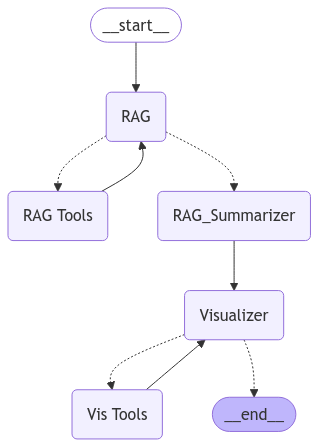

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [17]:
# def create_gradio_interface(agent):
#     def display_response(input_text):
#         result = agent.query_graph(input_text)
#         print("Inside interface")
#         print(result["html_code"])
#         return (
#             result["html_code"],
#             result["reply"]
#         )
    
#     css = """
#         #visualization-container {
#             width: 100%;
#             margin: 0;
#             padding: 0;
#         }
#         #visualization-container iframe {
#             width: 100%;
#             height: 600px;
#             border: none;
#         }
#     """
    
#     with gr.Blocks(css=css) as interface:
#         gr.Markdown("# Graph Analysis Interface")
        
#         with gr.Column():
#             input_text = gr.Textbox(
#                 label="Query",
#                 placeholder="Enter your graph query here...",
#                 lines=2
#             )
            
#             submit_btn = gr.Button("Analyze", variant="primary")
            
#             html_output = gr.HTML(
#                 label="Visualization",
#                 value="",
#                 elem_id="visualization-container"
#             )
            
#             text_output = gr.Textbox(
#                 label="Analysis Result", 
#                 lines=3
#             )
            
#         submit_btn.click(
#             fn=display_response,
#             inputs=[input_text],
#             outputs=[html_output, text_output]
#         )
    
#     return interface

In [18]:
def create_gradio_interface(agent):
    # ... (keep get_sample_data and display_response functions the same)
    def get_sample_data():
        # Get sample user IDs
        user_cursor = G_adb.query("""
        FOR user IN Users
        SORT RAND()
        LIMIT 3
        RETURN user._id
        """)
        sample_users = [user for user in user_cursor]

        # Get top games by player count
        games_cursor = G_adb.query("""
        WITH Games, plays
        FOR game IN Games
        LET playerCount = (
            FOR play IN plays 
            FILTER play._to == game._id 
            COLLECT WITH COUNT INTO length 
            RETURN length
        )[0]
        SORT playerCount DESC
        LIMIT 5
        RETURN game.GameName
        """)
        sample_games = [game for game in games_cursor]

        return sample_users, sample_games

    def display_response(input_text):
        result = agent.query_graph(input_text)
        print("Inside interface")
        print(result["html_code"])
        return (
            result["html_code"],
            result["rag_reply"]
        )
    
    # Get sample data from graph
    sample_users, sample_games = get_sample_data()
    css = """
         /* Reset any Gradio margins/padding */
        .gradio-container {
            margin: 0 !important;
            padding: 0 !important;
        }
        
        /* Main visualization container */
        #visualization-container {
            width: 100% !important;
            height: 1200px !important;
            margin: 0;
            padding: 0;
            overflow: hidden;
            position: relative;
        }
        
        /* Target the iframe directly */
        #visualization-container iframe {
            width: 100% !important;
            height: 100% !important;
            border: none !important;
            margin: 0 !important;
            padding: 0 !important;
            position: absolute !important;
            top: 0 !important;
            left: 0 !important;
        }

        /* Ensure the column takes full width */
        .svelte-1lyxibv {
            max-width: none !important;
        }
    """
    
    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# Graph Analysis Interface")
         
        with gr.Row():
            with gr.Column(scale=2):
                input_text = gr.Textbox(
                    label="Query",
                    placeholder="Enter your graph query here...",
                    lines=2
                )
                submit_btn = gr.Button("Analyze", variant="primary")
            
            # Sample IDs panel
            with gr.Column(scale=1):
                with gr.Column(elem_classes=["sample-panel"]):
                    # Format the sample data into markdown
                    users_md = "\n".join([f"- {user}" for user in sample_users])
                    games_md = "\n".join([f"- {game}" for game in sample_games])
                    
                    gr.Markdown(f"""
                    ### Sample User IDs
                    {users_md}

                    ### Popular Games
                    {games_md}
                    """)
        
        with gr.Column():
            html_output = gr.HTML(
                label="Visualization",
                value="",
                elem_id="visualization-container",
                container=False,
                

            )
            
            text_output = gr.Textbox(
                label="Analysis Result", 
                lines=3
            )
            
        submit_btn.click(
            fn=display_response,
            inputs=[input_text],
            outputs=[html_output, text_output]
        )
    
    return interface

In [19]:
# Assuming G_adb is already defined and is a NetworkX Graph object
import networkx as nx

# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G_adb)

# Filter out the game nodes
game_nodes = [node for node, data in G_adb.nodes(data=True) if data.get('type') == 'Games']

# Get the game with the highest degree centrality
most_influential_game = max(game_nodes, key=lambda node: degree_centrality.get(node, 0))

# Retrieve the node data for the most influential game
FINAL_RESULT = G_adb.nodes[most_influential_game]

[02:35:01 -0600] [INFO]: Graph 'SteamGraph' load took 3.8381364345550537s


In [20]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



Processing Agent State:
[ HumanMessage(content='Identifies users who bridge different gaming communities', additional_kwargs={}, response_metadata={}, id='6e5dfcf0-6c6d-4cfe-baa7-d34c03237c23')]

==== RAG PROMPT ====
SYSTEM: You are a Graph Analysis Planner. Follow these steps:
                1. Analyze the user's query for batch processing opportunities
                2. ALWAYS examine existing data in the state BEFORE making new tool calls  
                3. Create optimized steps using available tools
                4. Prefer single comprehensive queries over multiple small ones
                5. Use aggregation and grouping where possible
                6. Combine results for final answer

                Rules:
                → FIRST check if needed data already exists in Current Data at hand
                → ALL tools have access to the Current Data at hand - no need to re-fetch existing data
                → Look for ways to handle multiple items in one tool call
    

[02:35:42 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:35:45 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:35:45 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:35:45 -0600] [WARNING]: Database environment variables not set. Can't connect to the database


Converted FINAL_RESULT to serializable format
----------
FINAL_RESULT: {'num_communities': 70, 'bridging_users': [{'user_node': 'Users/111498455', 'connected_communities': [32, 18, 28, 38], 'user_data': {'data': {'_id': 'Users/111498455', '_key': '111498455', 'steamid': 111498455, 'type': 'Users'}}}, {'user_node': 'Users/199659716', 'connected_communities': [32, 4, 54, 68], 'user_data': {'data': {'_id': 'Users/199659716', '_key': '199659716', 'steamid': 199659716, 'type': 'Users'}}}, {'user_node': 'Users/216487495', 'connected_communities': [8, 54], 'user_data': {'data': {'_id': 'Users/216487495', '_key': '216487495', 'steamid': 216487495, 'type': 'Users'}}}, {'user_node': 'Users/97883175', 'connected_communities': [32, 18], 'user_data': {'data': {'_id': 'Users/97883175', '_key': '97883175', 'steamid': 97883175, 'type': 'Users'}}}, {'user_node': 'Users/244485884', 'connected_communities': [8, 54], 'user_data': {'data': {'_id': 'Users/244485884', '_key': '244485884', 'steamid': 24448588

[02:41:15 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:41:16 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:41:17 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:41:17 -0600] [WARNING]: Database environment variables not set. Can't connect to the database


Converted FINAL_RESULT to serializable format
----------
FINAL_RESULT: {'num_communities': 72, 'community_details': [{'community_id': 0, 'size': 2, 'composition': {'Users': 1, 'Games': 1}}, {'community_id': 1, 'size': 430, 'composition': {'Users': 292, 'Games': 138}}, {'community_id': 2, 'size': 17, 'composition': {'Users': 16, 'Games': 1}}, {'community_id': 3, 'size': 2, 'composition': {'Games': 1, 'Users': 1}}, {'community_id': 4, 'size': 2, 'composition': {'Games': 1, 'Users': 1}}, {'community_id': 5, 'size': 2, 'composition': {'Users': 1, 'Games': 1}}, {'community_id': 6, 'size': 469, 'composition': {'Users': 316, 'Games': 153}}, {'community_id': 7, 'size': 2, 'composition': {'Games': 1, 'Users': 1}}, {'community_id': 8, 'size': 2, 'composition': {'Games': 1, 'Users': 1}}, {'community_id': 9, 'size': 211, 'composition': {'Users': 134, 'Games': 77}}, {'community_id': 10, 'size': 2, 'composition': {'Games': 1, 'Users': 1}}, {'community_id': 11, 'size': 5, 'composition': {'Users': 4, 

[02:43:22 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:43:24 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:43:24 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[02:43:24 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
